In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import linear_model

In [21]:
basedir = '/scratch/sbanerj/quasi_laplace_gwas/'
simdir = 'simulations/sim041'
study = 'G1'
lnfile = os.path.join(basedir, 'LOCUSNAMES.MAXSNPS')
phenofile = os.path.join(basedir, simdir, 'samples/{:s}/phenotypes.sample'.format(study))

with open(lnfile, 'r') as mfile:
    locusprefixes = [line.strip() for line in mfile]

colnames = ['dum', 'missing', 'father', 'mother', 'sex', 'age', 'pheno']
dropnames = ['dum', 'missing', 'father', 'mother']
phenodf = pd.read_csv(phenofile, delimiter=' ', names = colnames, header=None, skiprows=2, index_col=0)
phenodf.drop(dropnames, inplace=True, axis=1)

snplistfile = os.path.join(basedir, simdir, 'samples/{:s}/snps.effectsize'.format(study))
colnames = ['beta']
betadf = pd.read_csv(snplistfile, header=None, names=colnames, delimiter = '\t', index_col=0)
betadf.index = [x.strip() for x in betadf.index.tolist()]

gt = pd.DataFrame(columns=phenodf.index.tolist())
for locusprefix in locusprefixes:
    dosagefile = os.path.join(basedir, 'loci_dosages', '{:s}/{:s}.matgen'.format(study, locusprefix))
    colnames = ['ref', 'alt'] + phenodf.index.tolist()
    dosage = pd.read_csv(dosagefile, header=None, names=colnames, delimiter=',', index_col=0)
    common_snps = [x for x in dosage.index.tolist() if x in betadf.index.tolist()]
    locusgt = dosage.loc[common_snps].drop(['ref', 'alt'], axis=1)
    gt = gt.append(locusgt)

mbeta = betadf.loc[gt.index.tolist()]

phenodf['xval'] = np.dot(np.array(gt).T, (np.array(mbeta)))

clf = linear_model.LogisticRegression(C=1e5)
X = np.array(gt).T
y = np.array(phenodf['pheno'])
clf.fit(X, y)
phenodf['logistic_proba'] = clf.predict_proba(X)[:, 1]

ols = linear_model.LinearRegression()
ols.fit(X, y)
phenodf['linear_proba'] = ols.predict(X)

outfile = os.path.join(basedir, simdir, 'logistic_data_{:s}.txt'.format(study))
phenodf.to_csv(outfile)

In [32]:
case_xvals = phenodf[phenodf['pheno'] == 1]['xval']
ctrl_xvals = phenodf[phenodf['pheno'] == 0]['xval']
case_logmodel = phenodf[phenodf['pheno'] == 1]['logistic_proba']
ctrl_logmodel = phenodf[phenodf['pheno'] == 0]['logistic_proba']
case_linmodel = phenodf[phenodf['pheno'] == 1]['linear_proba']
ctrl_linmodel = phenodf[phenodf['pheno'] == 0]['linear_proba']

In [33]:
mbins = np.linspace(-3, 1, 21)
ncase, _ = np.histogram(case_xvals, bins = mbins)
nctrl, _ = np.histogram(ctrl_xvals, bins = mbins)
ncase = ncase / phenodf.shape[0]
nctrl = - nctrl / phenodf.shape[0]

In [34]:
mbincentres = [(mbins[i] + mbins[i+1]) / 2 for i in range(mbins.shape[0] - 1)]

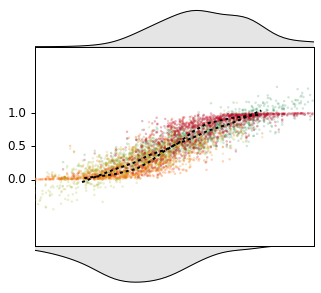

In [62]:
bordercolor = '#000000'
borderwidth = 1
axis_font_size = 30
label_font_size = 12
legend_font_size = 25

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(7, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1:6, 0])
ax3 = fig.add_subplot(gs[6, 0])

colors = ['#C10020', '#FF6800', '#007D34', '#93AA00', ]

x = mbincentres

y = ncase
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(x[0], x[-1], 101)
ax1.plot(xnew, f2(xnew), color = bordercolor, lw = borderwidth, zorder = 10)
ncasemax = max(f2(xnew))
ax1.fill_between(xnew, f2(xnew), 0, color = bordercolor, alpha = 0.1, zorder = 5)
ax2.scatter(case_xvals, case_logmodel, alpha=0.3, s=2, color=colors[0], facecolors='none', zorder=30)
ax2.scatter(case_xvals, case_linmodel, alpha=0.2, s=2, color=colors[2], facecolors='none', zorder=20)

y = nctrl
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(x[0], x[-1], 101)
ax3.plot(xnew, f2(xnew), color=bordercolor, lw=borderwidth, zorder=10)
nctrlmin = min(f2(xnew))
ax3.fill_between(xnew, f2(xnew), 0, color=bordercolor, alpha=0.1, zorder=5)
ax2.scatter(ctrl_xvals, ctrl_logmodel, alpha=0.3, s=2, color=colors[1], facecolors='none', zorder=20)
ax2.scatter(ctrl_xvals, ctrl_linmodel, alpha=0.2, s=2, color=colors[3], facecolors='none', zorder=20)

nbins = 10
xvals = np.array(phenodf['xval'])
logprobs = np.array(phenodf['logistic_proba'])
linprobs = np.array(phenodf['linear_proba'])

bins = np.percentile(logprobs, np.linspace(0, 100, nbins + 1))
bincentres = [(bins[i] + bins[i+1]) / 2 for i in range(nbins)]
binidx = np.digitize(logprobs, bins)
xmean = np.zeros(nbins)
for i in range(nbins):
    xsplit = xvals[np.where(binidx == i + 1)]
    xmean[i] = np.median(xsplit)
ax2.plot(xmean, bincentres, lw = 2, color= bordercolor, dashes = [3, 3], zorder=40)

bins = np.percentile(linprobs, np.linspace(0, 100, nbins + 1))
#bincentres = [(bins[i] + bins[i+1]) / 2 for i in range(nbins)]
binidx = np.digitize(linprobs, bins)
ymean = np.zeros(nbins)
xmean = np.zeros(nbins)
for i in range(nbins):
    xsplit = xvals[np.where(binidx == i + 1)]
    ysplit = linprobs[np.where(binidx == i + 1)]
    xmean[i] = np.median(xsplit)
    ymean[i] = np.median(ysplit)
ax2.plot(xmean, ymean, lw = 2, color= bordercolor, dashes = [3, 3], zorder=40)

ax1.set_ylim(0, ncasemax * 1.1)
ax3.set_ylim(nctrlmin * 1.1, 0)
for ax in [ax1, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
ax2.set_yticks([0.0, 0.5, 1.0])
ax2.set_xticks([])
ax2.tick_params(axis='both', which = 'major',
                length = 4, width = borderwidth, pad=5,
                direction = 'out',
                labelsize = label_font_size,
                color = bordercolor,
                labelcolor = bordercolor,
                bottom = False, top = False, left = True, right = False
               )
for side, border in ax2.spines.items():
    border.set_linewidth(borderwidth)
    border.set_color(bordercolor)


#ax2.set_ylim(-0.2, 1.2)
xmin = np.percentile(xvals, 1)
xmax = np.percentile(xvals, 99)
ax1.set_xlim(xmin, xmax)
ax2.set_xlim(xmin, xmax)
ax3.set_xlim(xmin, xmax)

plt.subplots_adjust(hspace=0)
plt.show()

In [63]:
xmean

array([-0.9369, -0.6967, -0.5325, -0.4451, -0.3121, -0.2342, -0.119 ,
       -0.005 ,  0.1703,  0.3912])

In [64]:
bincentres

[0.020913261088020579,
 0.077888131106205516,
 0.16438550712991479,
 0.27611604986221433,
 0.41637895046894424,
 0.56788097900521828,
 0.71759924290504284,
 0.84371778895930494,
 0.92709064709800315,
 0.98049048478776335]

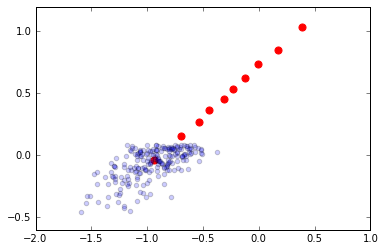

In [66]:
plt.scatter(xmean, ymean, color='red', s = 50)
plt.scatter(xvals[np.where(binidx == 0 + 1)], linprobs[np.where(binidx == 0 + 1)], alpha = 0.2)
plt.show()

In [59]:
np.min(linprobs)

-0.45422900530422428

In [60]:
bins

array([-0.4542,  0.0855,  0.2172,  0.3168,  0.4056,  0.4955,  0.5793,
        0.6793,  0.7895,  0.931 ,  1.5534])

In [61]:
np.max(linprobs)

1.5533892789246737